In [59]:
'''
%%writefile ns.py
start = time.time()
end = time.time()
print(end-start)
'''
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import sys
from pathlib import Path
import sklearn as sk 
import time
import scipy.stats as stats
from sklearn.preprocessing.data import QuantileTransformer
from tensorflow.keras import regularizers
import requests
import json

mhsdir = Path(os.getcwd()).parent
sys.path.append(os.path.join(mhsdir, 'src'))

import ns

datarawdir = os.path.join(mhsdir, 'data\\raw\\YC')
dataprepdir = os.path.join(mhsdir, 'data\\preprocessed')
dataprepnsdir = os.path.join(mhsdir, 'data\\preprocessed\\ns')
modeldir = os.path.join(mhsdir, 'models')

tempdatarawdir = os.path.join(mhsdir, 'temp\\data\\raw\\YC')
tempdataprepdir = os.path.join(mhsdir, 'temp\\data\\preprocessed')
tempdataprepnsdir = os.path.join(mhsdir, 'temp\\data\\preprocessed\\ns')

tfk = tf.keras
tfkl = tf.keras.layers

#train_csv = os.path.join(traindir, 'train_real_0_0_410_38_40938.txt')
#test_csv = os.path.join(traindir, 'train_real_410_0_9132.txt')

# Final preprocessing

In [60]:
df = None
traindir = os.path.join(mhsdir, 'data\\train\\repository\\train')
testdir = os.path.join(mhsdir, 'data\\train\\repository\\test')

for filename in os.listdir(traindir):
    path=os.path.join(traindir, filename)
    df1 = pd.read_csv(path, sep = ';', header = None)
    if df is None:
        df = df1
        continue
    df = pd.concat([df, df1])
train_df = df.iloc[:,:-1]
test_df = pd.read_csv(os.path.join(testdir, "train_real.txt"), sep = ';', header = None).iloc[:,:-1]

lx = (test_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
test_df = test_df[~lx]
print(lx.sum())
lx = (train_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
train_df = train_df[~lx]
print(lx.sum())

for i in range(100):
    train_df = train_df.sample(frac = 1).reset_index(drop=True)
    
repodir = os.path.join(mhsdir, 'data\\train\\repository')

trainfilepath = os.path.join(repodir, 'train_{}'.format(train_df.shape[0]) )
train_df.to_csv(trainfilepath,index = False)

testfilepath = os.path.join(repodir, 'test_{}'.format(test_df.shape[0]) )
test_df.to_csv(testfilepath,index = False)

1
10958


In [61]:
testfilepath

'C:\\Users\\PLDD\\Practice\\GitHub\\Python\\MHS\\data\\train\\repository\\test_102229'

# Train and build model

In [63]:
def to_category(freqv): 
    res = np.zeros((freqv.shape[0],12))
    for i in range(freqv.shape[0]):
        if freqv[i] == 1:
            res[i] = np.array([1,1,1,1,1,1,1,1,1,1,1,1],dtype = 'float')
        elif freqv[i] == 2:
            res[i] = np.array([0,1,0,1,0,1,0,1,0,1,0,1],dtype = 'float') 
        elif freqv[i] == 3:
            res[i] = np.array([0,0,1,0,0,1,0,0,1,0,0,1],dtype = 'float')
        elif freqv[i] == 4:
            res[i] = np.array([0,0,0,1,0,0,0,1,0,0,0,1],dtype = 'float')
        elif freqv[i] == 6:
            res[i] = np.array([0,0,0,0,0,1,0,0,0,0,0,1],dtype = 'float')
        elif freqv[i] == 12:
            res[i] = np.array([0,0,0,0,0,0,0,0,0,0,0,1],dtype = 'float')
    return res

def convertor(df):
    df.columns = ['n','id','bmode','tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
           'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
           't1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20','t21',
           'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','smode','freq']
    act_columns = ['tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
               'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
               'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12']
    coup_columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'] 
    target = df[coup_columns].sum(axis=1)
    data = df[act_columns].copy()
    data.loc[:,coup_columns] = to_category(df['freq'])
    return data,target

def VaR(ar):
    sar = np.sort(ar)
    sz = sar.shape[0]
    rsk = np.rint(sz * (1 - np.array([0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9]))).astype('int')
    return sar[rsk]

In [66]:
train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)
train_data, train_target = convertor(train_df)
test_data, test_target = convertor(test_df)

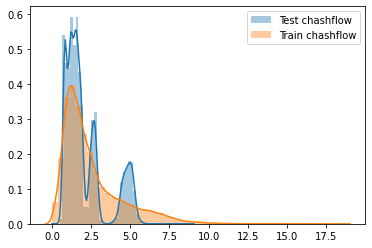

In [76]:
sn.distplot(test_target,label = 'Test chashflow')
sn.distplot(train_target,label = 'Train chashflow')
plt.legend()

In [77]:
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(128, activation='relu',input_shape = [len(train_data.keys())]),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    #tf.keras.layers.Dense(64, activation='relu'),
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.00001)),                 
                    #tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)),
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               7040      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [78]:
EPOCHS = 120
history = model.fit(
  train_data, train_target,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test_data,test_target))

Epoch 1/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.8429 - mae: 0.3125 - mse: 0.3418 - val_loss: 0.5443 - val_mae: 0.1625 - val_mse: 0.0447
Epoch 2/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.5597 - mae: 0.1637 - mse: 0.0617 - val_loss: 0.5336 - val_mae: 0.1462 - val_mse: 0.0371
Epoch 3/120
2485/2485 [==============================] - 9s 3ms/step - loss: 0.5405 - mae: 0.1393 - mse: 0.0455 - val_loss: 0.5278 - val_mae: 0.1400 - val_mse: 0.0343
Epoch 4/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.5291 - mae: 0.1252 - mse: 0.0371 - val_loss: 0.5254 - val_mae: 0.1420 - val_mse: 0.0349
Epoch 5/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.5206 - mae: 0.1158 - mse: 0.0316 - val_loss: 0.5167 - val_mae: 0.1325 - val_mse: 0.0291
Epoch 6/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.5140 - mae: 0.1086 - mse: 0.0279 - val_loss: 0.5162 - val_mae: 0.1371 - val_mse: 0.031

Epoch 50/120
2485/2485 [==============================] - 9s 4ms/step - loss: 0.3839 - mae: 0.0507 - mse: 0.0062 - val_loss: 0.3971 - val_mae: 0.1111 - val_mse: 0.0205
Epoch 51/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.3817 - mae: 0.0503 - mse: 0.0061 - val_loss: 0.3948 - val_mae: 0.1108 - val_mse: 0.0203
Epoch 52/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.3795 - mae: 0.0499 - mse: 0.0061 - val_loss: 0.3925 - val_mae: 0.1096 - val_mse: 0.0201
Epoch 53/120
2485/2485 [==============================] - 7s 3ms/step - loss: 0.3773 - mae: 0.0496 - mse: 0.0060 - val_loss: 0.3905 - val_mae: 0.1100 - val_mse: 0.0202
Epoch 54/120
2485/2485 [==============================] - 7s 3ms/step - loss: 0.3751 - mae: 0.0491 - mse: 0.0059 - val_loss: 0.3880 - val_mae: 0.1086 - val_mse: 0.0197
Epoch 55/120
2485/2485 [==============================] - 7s 3ms/step - loss: 0.3730 - mae: 0.0488 - mse: 0.0058 - val_loss: 0.3858 - val_mae: 0.1078 - val_mse:

Epoch 99/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.2929 - mae: 0.0392 - mse: 0.0037 - val_loss: 0.3034 - val_mae: 0.0919 - val_mse: 0.0149
Epoch 100/120
2485/2485 [==============================] - 10s 4ms/step - loss: 0.2914 - mae: 0.0391 - mse: 0.0037 - val_loss: 0.3019 - val_mae: 0.0917 - val_mse: 0.0150
Epoch 101/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.2899 - mae: 0.0390 - mse: 0.0037 - val_loss: 0.3003 - val_mae: 0.0913 - val_mse: 0.0148
Epoch 102/120
2485/2485 [==============================] - 9s 4ms/step - loss: 0.2884 - mae: 0.0389 - mse: 0.0037 - val_loss: 0.2989 - val_mae: 0.0911 - val_mse: 0.0149
Epoch 103/120
2485/2485 [==============================] - 9s 3ms/step - loss: 0.2870 - mae: 0.0388 - mse: 0.0036 - val_loss: 0.2970 - val_mae: 0.0922 - val_mse: 0.0144
Epoch 104/120
2485/2485 [==============================] - 8s 3ms/step - loss: 0.2855 - mae: 0.0387 - mse: 0.0036 - val_loss: 0.2958 - val_mae: 0.0903 - va

In [81]:
test_data, test_target = convertor(test_df)

In [84]:
y_act = test_target.to_numpy()
y_pred = model.predict(test_data).reshape(-1)

In [85]:
tt = 0
y_act[np.arange(tt,tt + 10)]

array([1.18537133, 2.73220146, 1.84703377, 5.09386162, 1.57846865,
       0.80353089, 1.8564979 , 1.1757947 , 2.77044464, 4.63006543])

In [86]:
y_pred[np.arange(tt,tt + 10)]

array([1.2354298 , 2.692048  , 1.968147  , 5.069069  , 1.4454699 ,
       0.91632915, 1.7768328 , 1.2623854 , 2.76855   , 4.5284705 ],
      dtype=float32)

In [92]:
data = json.dumps({"signature_name": "serving_default", "instances": test_data.iloc[0:10,:].to_numpy().tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/my_model:predict', data=data, headers=headers)
y = json.loads(json_response.text)['predictions']

In [93]:
y

[[1.23542988],
 [2.69204783],
 [1.96814704],
 [5.06906843],
 [1.44547021],
 [0.916329],
 [1.77683282],
 [1.26238525],
 [2.76854968],
 [4.52847052]]

In [94]:
test_data.iloc[0,:].to_numpy().tolist()

[0.027609464,
 0.084460575,
 0.028605499,
 0.091387847,
 0.446415799,
 0.479610879,
 0.6751365490000001,
 1.014547385,
 1.60320002,
 2.14233235,
 2.347963602,
 2.546451779,
 2.4710168930000003,
 2.683726272,
 2.734093925,
 2.767462746,
 2.905636983,
 2.849350569,
 2.880614107,
 2.895245082,
 3.0986459889999995,
 0.07307325099999999,
 -0.008032262,
 0.186080177,
 0.148017655,
 0.185715208,
 0.229250972,
 0.220293589,
 0.245410124,
 0.5540874729999999,
 0.207876796,
 0.142943682,
 0.116660347,
 0.410939428,
 0.087484566,
 0.048047507,
 0.108142032,
 -0.081075854,
 0.146218105,
 0.183238993,
 0.233222837,
 -0.009627712,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0]

In [48]:
def VaR(ar):
    sar = np.sort(ar)
    #sar = ar
    sz = sar.shape[0]
    rsk = np.rint(sz * (1 - np.array([0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9]))).astype('int')
    return sar[rsk]
pos = np.random.randint(0, 99000)
pos = 79770
y0 = y_act[np.arange(pos,pos + 3000)]
y1 = y_pred[np.arange(pos, pos + 3000)]
print(pos)
yy0 = VaR(y0)
print(yy0)
yy1 = VaR(y1)
print(yy1)
print(np.abs(yy1 - yy0))


79770
[0.67546956 0.70724589 0.73471233 0.75386061 0.77099774 0.78219504
 0.79739512 0.8157886  0.82617505 0.84009627]
[0.7281513  0.74845433 0.76635003 0.7803016  0.7937056  0.80751836
 0.82240856 0.8354641  0.8495789  0.86734843]
[0.05268176 0.04120844 0.0316377  0.02644096 0.02270784 0.02532333
 0.02501343 0.01967552 0.02340387 0.02725216]


In [33]:
dff = pd.DataFrame({'Act': test_target, 'Pred' : y_pred})
dff.describe()

,Act,Pred
count,102229.000000,102229.000000
mean,2.119526,2.076722
std,1.353206,1.310628
min,0.322815,0.380432
25%,1.168864,1.146918
50%,1.603277,1.558219
75%,2.647212,2.542322
max,8.725821,8.226402


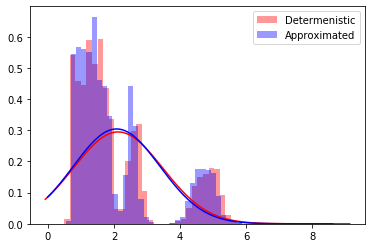

In [34]:
sn.distplot(y_act,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

In [79]:
version = 2
export_path = os.path.join(modeldir, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\2

INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\2\assets

Saved model:
